### Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

### Цель
Предсказать вероятность покупки в течение 90 дней

### Задачи
    ● Изучить данные
    ● Разработать полезные признаки
    ● Создать модель для классификации пользователей
    ● Улучшить модель и максимизировать метрику roc_auc
    ● Выполнить тестирование

In [1]:
!pip -q install phik
!pip -q install optuna 
!pip -q install optuna.integration


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: C:\Users\79823\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: C:\Users\79823\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: C:\Users\79823\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install "numpy<2.0"   # install the latest numpy 1.x version

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: C:\Users\79823\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: C:\Users\79823\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
# подгружаем библиотеки
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    PolynomialFeatures
)

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from catboost import CatBoostClassifier

from sklearn.metrics import (
    #r2_score,
    #mean_absolute_error,
    #mean_squared_error,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    make_scorer,
    roc_auc_score
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# import shap
from sklearn.feature_selection import SelectKBest, f_classif 

import optuna
from optuna import distributions
from imblearn.over_sampling import RandomOverSampler

### Загрузка данных

In [5]:
df_pur = pd.read_csv('filtered_data/apparel-purchases.csv', sep=',')
df_pur.head(20)   

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [6]:
df_pur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [7]:
df_pur.duplicated().sum()

73020

Дубликаты удалять не будем, возможно это повторные заказы за один день

In [8]:
df_mes = pd.read_csv('filtered_data/apparel-messages.csv', sep=',')
df_mes.head()   

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [9]:
df_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [10]:
df_mes.duplicated().sum()

48610

А тут удалим потому как это точно дубли, ведь время с точностью до секунд приянятого заказа

In [11]:
df_mes = df_mes.drop_duplicates()

In [12]:
df_tb = pd.read_csv('filtered_data/apparel-target_binary.csv', sep=',')
df_tb.head()   

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [13]:
df_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [14]:
df_tb.duplicated().sum()

0

In [15]:
df_tb['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Немалый дисбаланс классов, вернувшихся в 50 раз меньше

In [16]:
df_1 = pd.read_csv('filtered_data/full_campaign_daily_event_channel.csv', sep=',')
df_1.head()   

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

In [18]:
df_1.describe()

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


In [19]:
df_2 = pd.read_csv('filtered_data/full_campaign_daily_event.csv', sep=',')
df_2.head()  

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [20]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [21]:
df_2.describe()

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


Явных пропусков не обнаруженно, все датасеты загруженны

### Предобработка данных

In [22]:
# Узнаем сколько уникальных комбинаций категорий
len(df_pur['category_ids'].unique())

933

In [23]:
# А тут сколько категорий впринципе
list_A = df_pur['category_ids'].str.strip('[]').str.split(',\s*').explode().unique().tolist()
len(list_A)

1153

In [24]:
df_pur['category_ids'].unique()[:40]

array(["['4', '28', '57', '431']", "['4', '28', '244', '432']",
       "['4', '28', '49', '413']", "['2', '18', '258', '441']",
       "['2', '18', '341', '1311']", "['2', '18', '123', '451']",
       "['5562', '5631', '5549', '667']",
       "['5562', '5630', '5649', '678']", "['4', '27', '350', '1392']",
       "['4', '28', '44', '490']", "['2', '18', '267', '443']",
       "['4', '28', '213', '417']", "['5562', '5589', '5584', '1786']",
       "['5562', '5589', '5584', '1795']",
       "['5562', '5630', '5699', '550']",
       "['5562', '5634', '5579', '710']",
       "['5562', '5634', '5568', '957']",
       "['5562', '5634', '5693', '636']", "['2', '18', '344', '445']",
       "['4', '27', '353', '840']", "['4', '28', '343', '425']",
       "['4', '31', '326', '505']", "['4', '28', '260', '420']",
       "['5562', '5631', '5622', '560']",
       "['5562', '5631', '5549', '608']", "['4', '28', '290', '424']",
       "['2', '18', '212', '658']", "['4', '27', '142', '496']",
       "

Складывается ощущение что последнее число отражает комбинацию первых трех категорий, так что по идее можно оставить только последнее число

In [25]:
list_A = df_pur['category_ids']
list_A = list_A.str.strip("[]'', ")
list_B = list_A.str.split("', '")

print(list_B)

0          [4, 28, 57, 431]
1          [4, 28, 57, 431]
2          [4, 28, 57, 431]
3         [4, 28, 244, 432]
4          [4, 28, 49, 413]
                ...        
202203    [2, 18, 212, 726]
202204    [4, 27, 233, 462]
202205    [4, 27, 233, 462]
202206    [2, 18, 274, 446]
202207     [4, 28, 62, 656]
Name: category_ids, Length: 202208, dtype: object


In [26]:
list_C = []
for i in range(len(list_B)):
    list_C.append(list_B[i][-1:])
list_C = pd.Series(list_C).explode()
len(list_C.unique())

844

In [27]:
(list_C == '400').sum()

0

In [28]:
(list_C == '401').sum()

0

Заменим '' и None на 400 и 401, после проверки что таких категорий не было

In [29]:
list_C = list_C.str.strip("''").replace('None', 400).replace('', 401).astype(int)

Интересно есть решение оптимальнее, но за пару часов мне удалось выстрадать только подобное. Немного уменьшилось количество уникальных значений

In [30]:
df_pur['category_id'] = list_C
df_pur['category_id']

0         431
1         431
2         431
3         432
4         413
         ... 
202203    726
202204    462
202205    462
202206    446
202207    656
Name: category_id, Length: 202208, dtype: int32

In [31]:
df_pur.describe()

,client_id,quantity,price,category_id
count,2.022080e+05,202208.000000,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516,902.741009
std,1.459458e+08,0.184384,1342.252664,1056.744546
min,1.515916e+18,1.000000,1.000000,400.000000
25%,1.515916e+18,1.000000,352.000000,432.000000
50%,1.515916e+18,1.000000,987.000000,555.000000
75%,1.515916e+18,1.000000,1699.000000,765.000000
max,1.515916e+18,30.000000,85499.000000,6323.000000


Аномалий не видно, кто-то просто может покупать много, кто-то мало

In [32]:
len(df_pur['date'].unique())

642

уникальных дат много

In [33]:
df_pur['date'] = pd.to_datetime(df_pur['date'], format = '%Y-%m-%d')

In [34]:
df_pur.describe()

,client_id,quantity,price,date,category_id
count,2.022080e+05,202208.000000,202208.000000,202208,202208.000000
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064,902.741009
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00,400.000000
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00,432.000000
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00,555.000000
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00,765.000000
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00,6323.000000
std,1.459458e+08,0.184384,1342.252664,NaN,1056.744546


In [35]:
df_pur['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

Очень много покупок по единице товара, что поддерживает гипотезу о том, что дубликаты не дубликаты, а повторные заказы в этот же день

In [36]:
len(df_pur['client_id'].unique())

49849

Уникальных клиентов в 4 раза меньше чем общее количество заказов

In [37]:
def graph1(data, values, title):
    data[values].plot(kind='hist',
                                       bins=30,
                                       title=title
                                      );
    plt.xlabel(title);
    plt.ylabel('Частота');

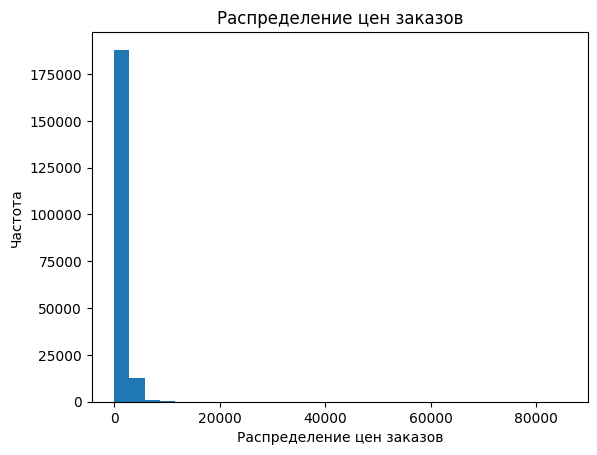

In [38]:
graph1(df_pur, 'price', 'Распределение цен заказов')

Как видно абсолютно большинство делало маленькие по цене заказы

In [39]:
# Аггрегируем таблицу
get_max = lambda x: x.value_counts(dropna=False).index[0]
grouped = df_pur.groupby('client_id', as_index=False)
aggregated = grouped.agg({
    'quantity': 'sum',
    'price': 'sum',
    'date': 'max', 
    'category_id': get_max,
    'message_id': get_max
})
df_agg_pur = pd.DataFrame(aggregated)

print(df_agg_pur.head())

             client_id  quantity    price       date  category_id  \
0  1515915625468060902         7   6993.0 2022-05-27          458   
1  1515915625468061003         7  16235.0 2023-01-04          615   
2  1515915625468061099         1    299.0 2022-05-17          424   
3  1515915625468061100         2   2098.0 2024-02-10         5717   
4  1515915625468061170        19  33601.0 2023-06-17          420   

                                message_id  
0   1515915625468060902-4617-6290657dac196  
1   1515915625468061003-9148-63b54b04855a4  
2   1515915625468061099-4439-62834141aa538  
3  1515915625468061100-14623-65c5c55eeb9e0  
4  1515915625468061170-11208-6423f082d2fcb  


Непридумал ничего лучше чем взять для каждого клиента его самую популярную категорию. Количество товаров и стоимоисть логично сложить, а дату взять наибольшую, дабы потом найти разницу по времени с датой последнего уведомления

In [40]:
df_agg_pur

,client_id,quantity,price,date,category_id,message_id
0,1515915625468060902,7,6993.0,2022-05-27,458,1515915625468060902-4617-6290657dac196
1,1515915625468061003,7,16235.0,2023-01-04,615,1515915625468061003-9148-63b54b04855a4
2,1515915625468061099,1,299.0,2022-05-17,424,1515915625468061099-4439-62834141aa538
3,1515915625468061100,2,2098.0,2024-02-10,5717,1515915625468061100-14623-65c5c55eeb9e0
4,1515915625468061170,19,33601.0,2023-06-17,420,1515915625468061170-11208-6423f082d2fcb
...,...,...,...,...,...,...
49844,1515915626010261344,6,8994.0,2024-02-16,726,1515915626010261344-14648-65cdb6d56c4c8
49845,1515915626010266132,2,1818.0,2024-02-14,470,1515915625999374481-14623-65c5c5acbad8c
49846,1515915626010439406,2,198.0,2024-02-16,462,1515915625776605028-14662-65cf3abfe4f0d
49847,1515915626010443527,1,1999.0,2024-02-16,446,1515915625766077627-14668-65cf5246bd490


In [41]:
df_agg_pur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   client_id    49849 non-null  int64         
 1   quantity     49849 non-null  int64         
 2   price        49849 non-null  float64       
 3   date         49849 non-null  datetime64[ns]
 4   category_id  49849 non-null  int32         
 5   message_id   49849 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 2.1+ MB


Агрегирование прошло успешно

In [42]:
df_mes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 774.6+ MB


In [43]:
len(df_mes['client_id'].unique())

53329

Чуть больше униакльных клиентов чем в прошлом датасете

In [44]:
len(df_mes['bulk_campaign_id'].unique())

2709

In [45]:
df_mes['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

Необычных значений нет

In [46]:
df_mes['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

Самое распространенное событые отправка сообщение, смущает закрытие (закрытие чего?), меньше всего подписок. Вопрос как агрегировать это столбец... 

In [47]:
df_mes['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

Ага, каналов рассылки всего два, при этом они соизмеримы по объему, хотя мобильные уведомления чуть впереди

In [48]:
df_mes['date'] = pd.to_datetime(df_mes['date'], format = '%Y-%m-%d')

In [49]:
df_mes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 774.6+ MB


In [50]:
X = pd.get_dummies(df_mes['event'])

In [51]:
df_mes = df_mes.join(X)

In [52]:
df_mes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
 7   click             bool          
 8   close             bool          
 9   complain          bool          
 10  hard_bounce       bool          
 11  hbq_spam          bool          
 12  open              bool          
 13  purchase          bool          
 14  send              bool          
 15  soft_bounce       bool          
 16  subscribe         bool          
 17  unsubscribe       bool          
dtypes: bool(11), datetime64[ns](1), int64(2), object(4)
memory usage: 907.7+ MB


нашлось решение, теперь можно аггрегировать)

Суммирование по типу каждого события должно быть более информативнее 
З.Ы. метрика при построении моделей действительно прилично выросла

In [53]:
# Агрегируем второй датасет

grouped = df_mes.groupby('client_id', as_index=False)
aggregated = grouped.agg({
    'bulk_campaign_id': get_max,
    'click': 'sum', 
    'close': 'sum', 
    'complain': 'sum', 
    'hard_bounce': 'sum', 
    'hbq_spam': 'sum', 
    'open': 'sum', 
    'purchase': 'sum', 
    'send': 'sum', 
    'soft_bounce': 'sum', 
    'subscribe': 'sum', 
    'unsubscribe': 'sum', 
    'channel': get_max,
    'date': 'max'
})
df_agg_mes = pd.DataFrame(aggregated)

print(df_agg_mes.head())

             client_id  bulk_campaign_id  click  close  complain  hard_bounce  \
0  1515915625468060902              4617     10      0         0            0   
1  1515915625468061003             12566      5      0         0            0   
2  1515915625468061099              9945      8      0         0            2   
3  1515915625468061100             14280      1      0         0            1   
4  1515915625468061170             11144     16      0         0            0   

   hbq_spam  open  purchase  send  soft_bounce  subscribe  unsubscribe  \
0         0    35         5   126            0          0            1   
1         0     5         1   154            0          0            0   
2         0    51         0   215            0          0            0   
3         0   157         1   267            1          0            0   
4         0    31         3   243            0          0            0   

       channel       date  
0        email 2024-01-19  
1        ema

Аггрегирование прошло успешно

In [54]:
df = df_tb.merge(df_agg_pur, on='client_id', how='left')
df.head()

,client_id,target,quantity,price,date,category_id,message_id
0,1515915625468060902,0,7,6993.0,2022-05-27,458,1515915625468060902-4617-6290657dac196
1,1515915625468061003,1,7,16235.0,2023-01-04,615,1515915625468061003-9148-63b54b04855a4
2,1515915625468061099,0,1,299.0,2022-05-17,424,1515915625468061099-4439-62834141aa538
3,1515915625468061100,0,2,2098.0,2024-02-10,5717,1515915625468061100-14623-65c5c55eeb9e0
4,1515915625468061170,0,19,33601.0,2023-06-17,420,1515915625468061170-11208-6423f082d2fcb


In [55]:
df = df.merge(df_agg_mes, on='client_id', how='left')
df.head()

,client_id,target,quantity,price,date_x,category_id,message_id,bulk_campaign_id,click,close,...,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,channel,date_y
0,1515915625468060902,0,7,6993.0,2022-05-27,458,1515915625468060902-4617-6290657dac196,4617.0,10.0,0.0,...,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,email,2024-01-19
1,1515915625468061003,1,7,16235.0,2023-01-04,615,1515915625468061003-9148-63b54b04855a4,12566.0,5.0,0.0,...,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,email,2024-02-13
2,1515915625468061099,0,1,299.0,2022-05-17,424,1515915625468061099-4439-62834141aa538,9945.0,8.0,0.0,...,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,email,2024-02-13
3,1515915625468061100,0,2,2098.0,2024-02-10,5717,1515915625468061100-14623-65c5c55eeb9e0,14280.0,1.0,0.0,...,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,mobile_push,2024-02-15
4,1515915625468061170,0,19,33601.0,2023-06-17,420,1515915625468061170-11208-6423f082d2fcb,11144.0,16.0,0.0,...,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,email,2024-02-15


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         49849 non-null  int64         
 1   target            49849 non-null  int64         
 2   quantity          49849 non-null  int64         
 3   price             49849 non-null  float64       
 4   date_x            49849 non-null  datetime64[ns]
 5   category_id       49849 non-null  int32         
 6   message_id        49849 non-null  object        
 7   bulk_campaign_id  41982 non-null  float64       
 8   click             41982 non-null  float64       
 9   close             41982 non-null  float64       
 10  complain          41982 non-null  float64       
 11  hard_bounce       41982 non-null  float64       
 12  hbq_spam          41982 non-null  float64       
 13  open              41982 non-null  float64       
 14  purchase          4198

Успешно объединили в финальный датафрейм, но есть беда, 8 тысяч клиентов нехватает в df_mes. Я не стал удалять пропуски это почти 20% датасета

In [57]:
# Введем новый признак разницу между последним уведомлением и последним заказом в днях
c = pd.to_datetime('2022-1-1', format = '%Y-%m-%d')
c

Timestamp('2022-01-01 00:00:00')

In [58]:
for i in df.index:
    if (df.loc[i, 'date_y']).year > 0:
        df.loc[i, 'days'] = (df.loc[i, 'date_y'] - df.loc[i, 'date_x']).days
    else: 
        df.loc[i, 'days'] = -(c - df.loc[i, 'date_x']).days

In [59]:
df.tail(20)

,client_id,target,quantity,price,date_x,category_id,message_id,bulk_campaign_id,click,close,...,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,channel,date_y,days
49829,1515915626009930549,0,1,249.0,2024-02-09,1806,1515915625490975573-14625-65c5edbb987a1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,769.0
49830,1515915626009932400,0,2,1400.0,2024-02-14,667,1515915626009932400-14632-65c9f5cc787ba,14632.0,1.0,0.0,...,0.0,3.0,1.0,3.0,0.0,0.0,0.0,mobile_push,2024-02-15,1.0
49831,1515915626009954872,0,1,399.0,2024-02-10,684,1515915626005925149-14625-65c5ed42946b9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,770.0
49832,1515915626010002078,0,3,2397.0,2024-02-14,1570,1515915625502068146-14646-65cc731fdd997,14649.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,mobile_push,2024-02-14,0.0
49833,1515915626010079153,0,8,15929.0,2024-02-13,663,1515915626010079153-14632-65c9f5c98af32,14632.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,mobile_push,2024-02-13,0.0
49834,1515915626010111769,0,1,1499.0,2024-02-13,1325,1515915625489040221-14625-65c5ed255e544,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,773.0
49835,1515915626010152263,0,4,1676.0,2024-02-14,443,1515915626010152263-14649-65cca1b63edf7,14649.0,2.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,mobile_push,2024-02-14,0.0
49836,1515915626010171640,0,2,2998.0,2024-02-13,1325,1515915625489040221-14625-65c5ed255e544,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,773.0
49837,1515915626010182877,0,1,5499.0,2024-02-13,661,1515915625487856726-14641-65cb23d5a6278,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,773.0
49838,1515915626010183608,0,4,568.0,2024-02-13,401,1515915625489302721-14623-65c5c5804cb67,14648.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,mobile_push,2024-02-15,2.0


Посмотрим на мультиколлинеарность

interval columns not set, guessing: ['target', 'quantity', 'price', 'days', 'category_id', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe']


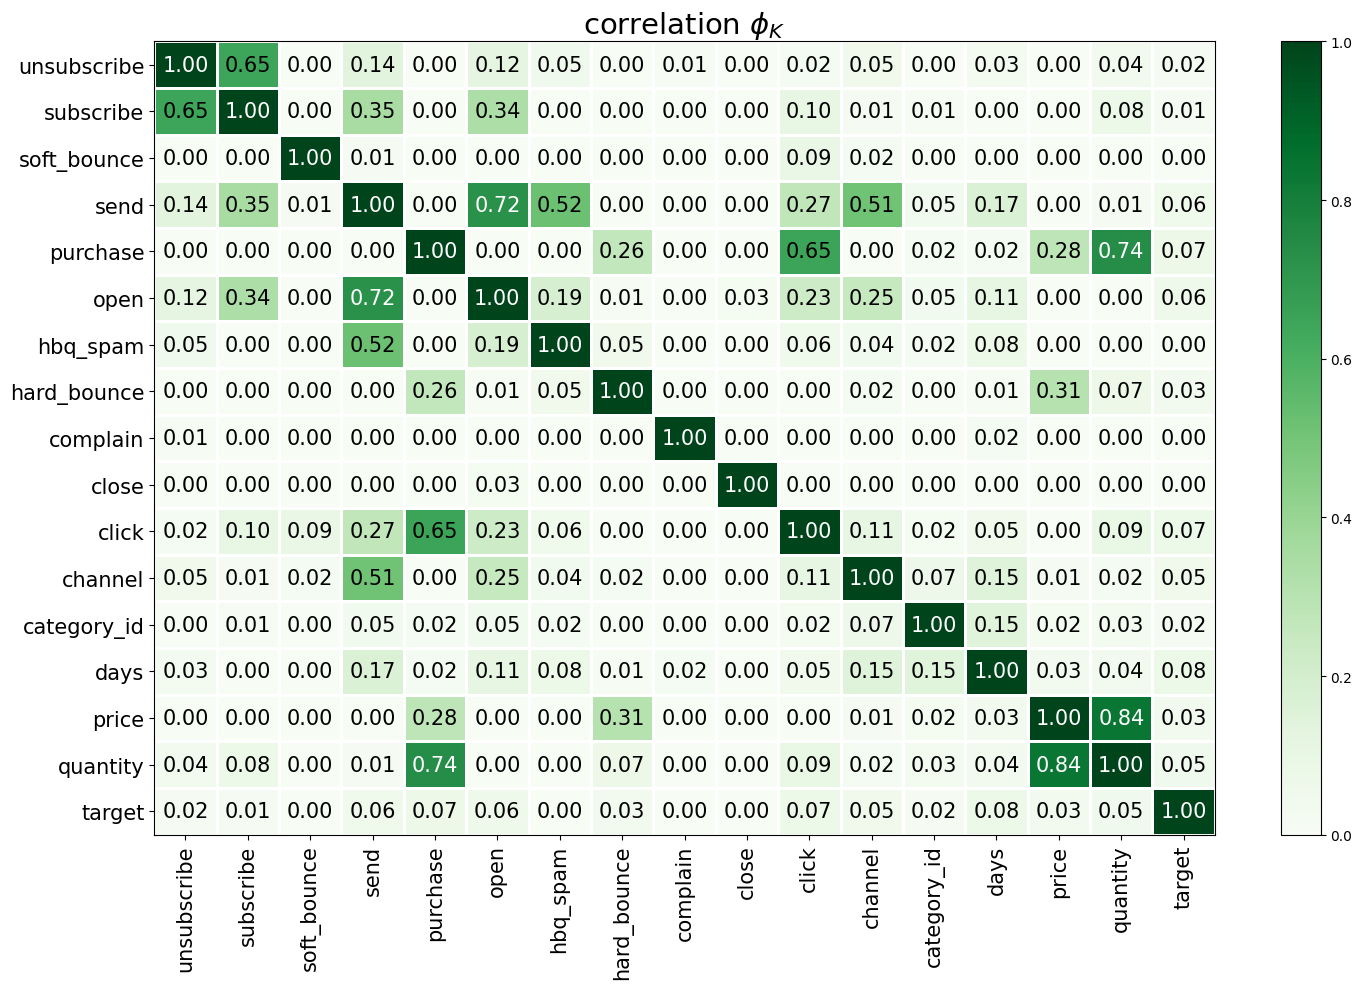

In [60]:
phik_overview = phik_matrix(df[['target', 'quantity', 'price', 'days', 'category_id', 'channel', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe']]);
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
);

Самая высокая корреляция у общей стоимости с общим количеством покупок, что в целом ожидаемо.
Мультиколлинеарности не наблюдается

### Обучение моделей

In [62]:
RANDOM_STATE = 123
TEST_SIZE = 0.25

X = df[['quantity', 'price', 'category_id', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'channel', 'days']]
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=df['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(37386, 16)
(37386,)
(12463, 16)
(12463,)


In [63]:
# Хотел попробовать оверсеплинг
ros = RandomOverSampler(
     sampling_strategy=0.5,
     random_state=RANDOM_STATE,
) 

X_res, y_res = ros.fit_resample(X_train, y_train)

Насколько тут нужен оверсеплинг? Нам важнее по лигике предсказание основного класса, т.е. 0

In [65]:
num_cols = ['quantity', 'price', 'days', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe']
cat_cols = ['category_id', 'channel']

In [66]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))
])

In [67]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

In [68]:
estimator = LogisticRegression()
clf_pipeline = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', estimator)
        ])
clf_pipeline.fit(X_res, y_res)
score = roc_auc_score(y_test, clf_pipeline.predict_proba(X_test)[:,1])
score

C:\Users\79823\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6182153181161198

In [69]:
clf = LogisticRegression()
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])
clf_pipeline.fit(X_res, y_res)
y_pred = clf_pipeline.predict(X_test)

C:\Users\79823\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


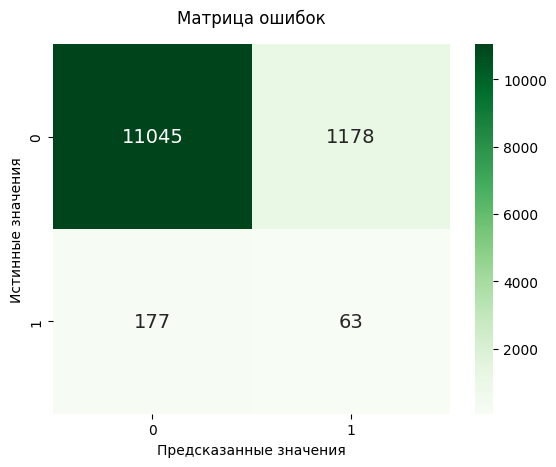

In [70]:
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

Модель довольно плохо находит TP значения, однако нам же важнее определить тех кто не проявит активность. В идеале модель должна минимально выдавать FP ошибки

In [73]:
def objective(trial):    
    # Список гиперпараметров для перебора (для KNeighborsClassifier)
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 2, 20)
    }

    
    # Определяю модель машинного обучения, которой передаются гиперпараметры
    estimator = KNeighborsClassifier(**param)

    # Прикручиваю пайплайны
    clf_pipeline = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', estimator)
        ])
    # Код для вычисления метрики качества.
    # В этом проекте я вычисляю Accuracy методом кросс-валидации
    
    clf_pipeline.fit(X_res, y_res)
    score = roc_auc_score(y_test, clf_pipeline.predict_proba(X_test)[:,1])
    return score

# Инициализирую подбора гиперпараметров.
study = optuna.create_study(direction="maximize")
# Запускаю процесс подбора гиперпараметров
study.optimize(objective, n_trials=10)
# Вывожу на экран лучший результат
print(study.best_trial)

[I 2025-04-28 05:16:33,238] A new study created in memory with name: no-name-1d7d227c-e9d9-46e0-a8e4-89eb878bee36
[I 2025-04-28 05:16:59,863] Trial 0 finished with value: 0.6030662821456816 and parameters: {'n_neighbors': 30}. Best is trial 0 with value: 0.6030662821456816.
[I 2025-04-28 05:17:26,329] Trial 1 finished with value: 0.6415597984673702 and parameters: {'n_neighbors': 69}. Best is trial 1 with value: 0.6415597984673702.
[I 2025-04-28 05:17:55,825] Trial 2 finished with value: 0.6083374239821103 and parameters: {'n_neighbors': 31}. Best is trial 1 with value: 0.6415597984673702.
[I 2025-04-28 05:18:21,868] Trial 3 finished with value: 0.5825518489732471 and parameters: {'n_neighbors': 18}. Best is trial 1 with value: 0.6415597984673702.
[I 2025-04-28 05:18:47,825] Trial 4 finished with value: 0.6428082985628186 and parameters: {'n_neighbors': 74}. Best is trial 4 with value: 0.6428082985628186.
[I 2025-04-28 05:19:15,018] Trial 5 finished with value: 0.5993151572172679 and p

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.6428082985628186], datetime_start=datetime.datetime(2025, 4, 28, 5, 18, 21, 868651), datetime_complete=datetime.datetime(2025, 4, 28, 5, 18, 47, 825731), params={'n_neighbors': 74}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=100, log=False, low=2, step=1)}, trial_id=4, value=None)


In [94]:
clf = KNeighborsClassifier(n_neighbors = 74)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])
clf_pipeline.fit(X_res, y_res)
y_pred = clf_pipeline.predict(X_test)

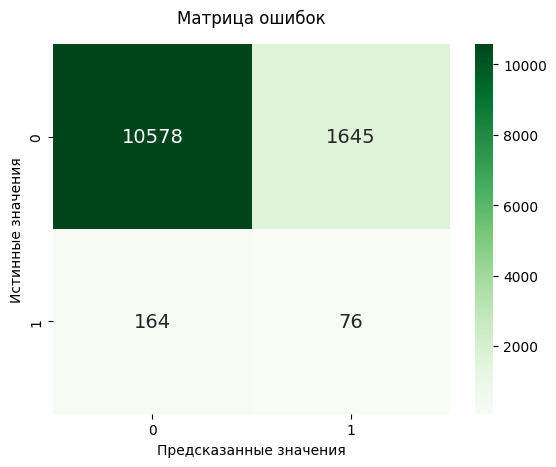

In [95]:
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

Модель работает неплохо, но очень много FN значений, по логике задачи лучше как можно меньше "терять" не вернувшихся клиентов ведь опредилив эту группу им можно делать более выгодные предложения к примеру чтобы их вернуть (ну и метрика не очень...)
З.Ы. Optuna для перебора одного гиперпараметра наверное странное решение, сделано для единообразия скорее

In [76]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    estimator = CatBoostClassifier(**params, silent=True)
        # Прикручиваю пайплайны
    clf_pipeline = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', estimator)
        ])
    # Код для вычисления метрики качества.
    clf_pipeline.fit(X_res, y_res)
    score = roc_auc_score(y_test, clf_pipeline.predict_proba(X_test)[:,1])
    return score

# Инициализирую подбора гиперпараметров.
study = optuna.create_study(direction="maximize")
# Запускаю процесс подбора гиперпараметров
study.optimize(objective, n_trials=50)
# Вывожу на экран лучший результат
print(study.best_trial)

[I 2025-04-28 05:21:16,476] A new study created in memory with name: no-name-1f3c897c-162d-47aa-b254-2802baedc586
[I 2025-04-28 05:21:20,614] Trial 0 finished with value: 0.6960673525321116 and parameters: {'learning_rate': 0.0017223794785422221, 'depth': 1, 'subsample': 0.9384562996948744, 'colsample_bylevel': 0.4279567963189806, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.6960673525321116.
[I 2025-04-28 05:21:50,073] Trial 1 finished with value: 0.7182759960729772 and parameters: {'learning_rate': 0.002668508833378437, 'depth': 8, 'subsample': 0.5671014890228292, 'colsample_bylevel': 0.3766644836131592, 'min_data_in_leaf': 25}. Best is trial 1 with value: 0.7182759960729772.
[I 2025-04-28 05:21:53,527] Trial 2 finished with value: 0.7152913564591344 and parameters: {'learning_rate': 0.010577552198393183, 'depth': 1, 'subsample': 0.6099714127178134, 'colsample_bylevel': 0.740364687366736, 'min_data_in_leaf': 74}. Best is trial 1 with value: 0.7182759960729772.
[I 2025-04-28

FrozenTrial(number=41, state=TrialState.COMPLETE, values=[0.7252825956530038], datetime_start=datetime.datetime(2025, 4, 28, 5, 28, 2, 790602), datetime_complete=datetime.datetime(2025, 4, 28, 5, 28, 13, 562950), params={'learning_rate': 0.004946322306143049, 'depth': 5, 'subsample': 0.15499148908875843, 'colsample_bylevel': 0.36123769274645245, 'min_data_in_leaf': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'depth': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=1, step=1)}, trial_id=41, value=None)


roc_auc = 72.5, нормальный результат, до оверсеиплинга, я получал результаты лучше (около 75), однако дисбаланс классов был гораздо сильнее

In [92]:
clf = CatBoostClassifier(learning_rate= 0.004946322306143049, depth= 5, subsample= 0.15499148908875843, colsample_bylevel= 0.36123769274645245, min_data_in_leaf= 10, random_state=RANDOM_STATE)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])
clf_pipeline.fit(X_res, y_res)
y_pred = clf_pipeline.predict(X_test)

0:	learn: 0.6918304	total: 10.4ms	remaining: 10.4s
1:	learn: 0.6906008	total: 21ms	remaining: 10.5s
2:	learn: 0.6893804	total: 30.3ms	remaining: 10.1s
3:	learn: 0.6882596	total: 39.2ms	remaining: 9.77s
4:	learn: 0.6870281	total: 47.8ms	remaining: 9.51s
5:	learn: 0.6859946	total: 67ms	remaining: 11.1s
6:	learn: 0.6847713	total: 75.5ms	remaining: 10.7s
7:	learn: 0.6836197	total: 83.6ms	remaining: 10.4s
8:	learn: 0.6827038	total: 92.2ms	remaining: 10.1s
9:	learn: 0.6814738	total: 102ms	remaining: 10.1s
10:	learn: 0.6804774	total: 115ms	remaining: 10.3s
11:	learn: 0.6793860	total: 124ms	remaining: 10.2s
12:	learn: 0.6783181	total: 145ms	remaining: 11s
13:	learn: 0.6772854	total: 154ms	remaining: 10.8s
14:	learn: 0.6765431	total: 163ms	remaining: 10.7s
15:	learn: 0.6755033	total: 178ms	remaining: 11s
16:	learn: 0.6744675	total: 187ms	remaining: 10.8s
17:	learn: 0.6734951	total: 196ms	remaining: 10.7s
18:	learn: 0.6724081	total: 205ms	remaining: 10.6s
19:	learn: 0.6713551	total: 214ms	remain

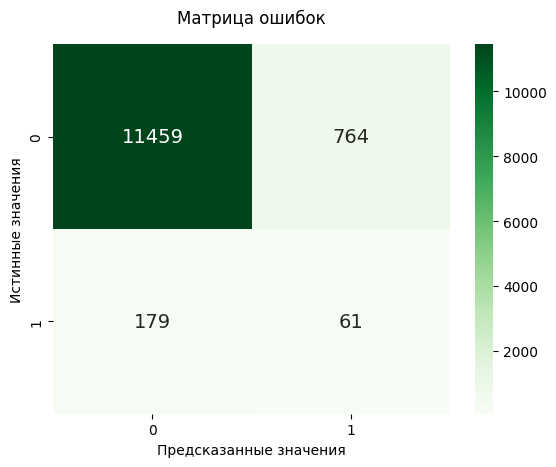

In [93]:
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

Самый лучший результат из полученных мной, FP ошибок меньше, хотя FN чуть больше чем у самой стандарной логистической регрессии, но последнее по-идее не так важно как первое

лучшая модель:

    CatBoostClassifier
параметры лучшей модели:

    learning_rate= 0.004946322306143049, depth= 5, subsample= 0.15499148908875843, colsample_bylevel= 0.36123769274645245, min_data_in_leaf= 10
значение метрики roc_auc:

    72.5
дополнительно:

    данная модель дает меньше всего FP ошибок из опробованных мной

З.Ы. Буду рад услышать какие еще модели стоило/можно было попробовать

### Выводы

1) Данные были успещно загружены и проведен предварительный просмотр
2) Проанализованы данные основных трех датасетов (каюсь не сообразил как адекватно получить информации из агрегированных по дате, хотя именно эти датасеты натолкнули меня на мысль на сооздание столбцов с подсчетом каждого конкретного события для агрегирования датасета сообщений по пользователям)
3) Преобразован столбец с категориями дабы ввести новый столбец куда входит последняя (как я считаю главная) категория
4) Проведена аггрегация датасетов с заказами и сообщений с последующим объединением датасетов с датасетом с таргетом
5) При агрегации были введены новые признаки: к примеру самая частая частая категрия или сумма всех заказов или последня дата заказа для данного клиента, столбцы с подсчетом каждого конкретного события для датасета сообщений по пользователям
6) Введен признак разницы в днях между последним заказом и последним событием (из датасета сообщений) для пользователя (идея отфильтровать пользователей которые допустим отписались от рассылки приличное время назад и не получают и не открывают сообщения)
7) Проведена проверка на мультиколлинераность
8) Обученно 3 модели + подбор гиперпараметров через optuna
9) лучшая модель: CatBoostClassifier параметры лучшей модели: learning_rate= 0.004946322306143049, depth= 5, subsample= 0.15499148908875843, colsample_bylevel= 0.36123769274645245, min_data_in_leaf= 10 значение метрики roc_auc: 72.5 дополнительно: данная модель дает меньше всего FP ошибок из опробованных мной